In [1]:
cd ../app

D:\API\CVX\app


载入一些包：

In [3]:
import time
from mxnet import nd, init, gluon, autograd, contrib, image
from mxnet.gluon import loss as gloss, nn
import d2lzh as d2l

from detection.ssd import TinySSD

目标检测数据集：[皮卡丘](https://zh.gluon.ai/chapter_computer-vision/object-detection-dataset.html)

In [4]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_classes = 1

In [5]:
batch_size = 32
train_iter, _ = d2l.load_data_pikachu(batch_size)

ctx, net = d2l.try_gpu(), TinySSD(sizes, ratios, num_classes)
net.initialize(init=init.Xavier(), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'learning_rate': 0.2, 'wd': 5e-4})

In [6]:
cls_loss = gloss.SoftmaxCrossEntropyLoss()
bbox_loss = gloss.L1Loss()

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    return cls + bbox

In [7]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维
    return (cls_preds.argmax(axis=-1) == cls_labels).sum().asscalar()

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return ((bbox_labels - bbox_preds) * bbox_masks).abs().sum().asscalar()

# 训练

In [32]:
train_iter, _ = d2l.load_data_pikachu(batch_size)
for batch in train_iter:
    X = batch.data[0].as_in_context(ctx)
    Y = batch.label[0].as_in_context(ctx)
    anchors, cls_preds, bbox_preds = net(X)
    print(X.shape, Y.shape, anchors.shape, cls_preds.shape, bbox_preds.shape)
    bbox_labels, bbox_masks, cls_labels = contrib.nd.MultiBoxTarget(
                anchors, Y, cls_preds.transpose((0, 2, 1)))
    break

(32, 3, 256, 256) (32, 1, 5) (1, 5444, 4) (32, 5444, 2) (32, 21776)


In [8]:
for epoch in range(20):
    acc_sum, mae_sum, n, m = 0.0, 0.0, 0, 0
    train_iter.reset()  # 从头读取数据
    start = time.time()
    for batch in train_iter:
        X = batch.data[0].as_in_context(ctx)
        Y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            # 生成多尺度的锚框，为每个锚框预测类别和偏移量
            anchors, cls_preds, bbox_preds = net(X)

            # 为每个锚框标注类别和偏移量
            bbox_labels, bbox_masks, cls_labels = contrib.nd.MultiBoxTarget(
                anchors, Y, cls_preds.transpose((0, 2, 1)))
            # 根据类别和偏移量的预测和标注值计算损失函数
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                          bbox_masks)
        l.backward()
        trainer.step(batch_size)
        acc_sum += cls_eval(cls_preds, cls_labels)
        n += cls_labels.size
        mae_sum += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        m += bbox_labels.size

    if (epoch + 1) % 5 == 0:
        print('epoch %2d, class err %.2e, bbox mae %.2e, time %.1f sec' % (
            epoch + 1, 1 - acc_sum / n, mae_sum / m, time.time() - start))

epoch  5, class err 2.78e-03, bbox mae 3.17e-03, time 44.2 sec
epoch 10, class err 2.64e-03, bbox mae 2.96e-03, time 46.9 sec
epoch 15, class err 2.45e-03, bbox mae 2.68e-03, time 44.0 sec
epoch 20, class err 2.43e-03, bbox mae 2.61e-03, time 44.6 sec


# 预测

In [9]:
img = image.imread('../images/pikachu.jpg')
feature = image.imresize(img, 256, 256).astype('float32')
X = feature.transpose((2, 0, 1)).expand_dims(axis=0)

In [10]:
def predict(X):
    anchors, cls_preds, bbox_preds = net(X.as_in_context(ctx))
    cls_probs = cls_preds.softmax().transpose((0, 2, 1))
    output = contrib.nd.MultiBoxDetection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0].asscalar() != -1]
    return output[0, idx]

output = predict(X)

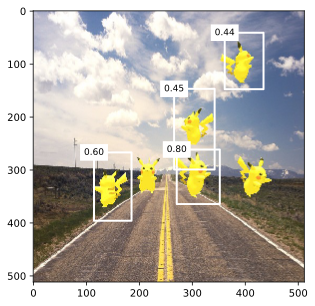

In [12]:
d2l.set_figsize((5, 5))

def display(img, output, threshold):
    fig = d2l.plt.imshow(img.asnumpy())
    for row in output:
        score = row[1].asscalar()
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * nd.array([w, h]*2, ctx=row.context)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output, threshold=0.3)